---
title: "GIOZA Case Study: Energy Analysis"
format:
  html:
    toc: true
    toc-title: Contents
    toc-depth: 4
    code-fold: show
    self-contained: true
jupyter: python3
---

# Loading Packages and Data

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotnine import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
factory_energy = pd.read_csv('data/energy_consumption.csv')
# convert predictors into proper datatype
factory_energy['at'] = pd.to_datetime(factory_energy['at'])
factory_energy = factory_energy.sort_values(by=['at'], ascending=True).reset_index(drop=True)

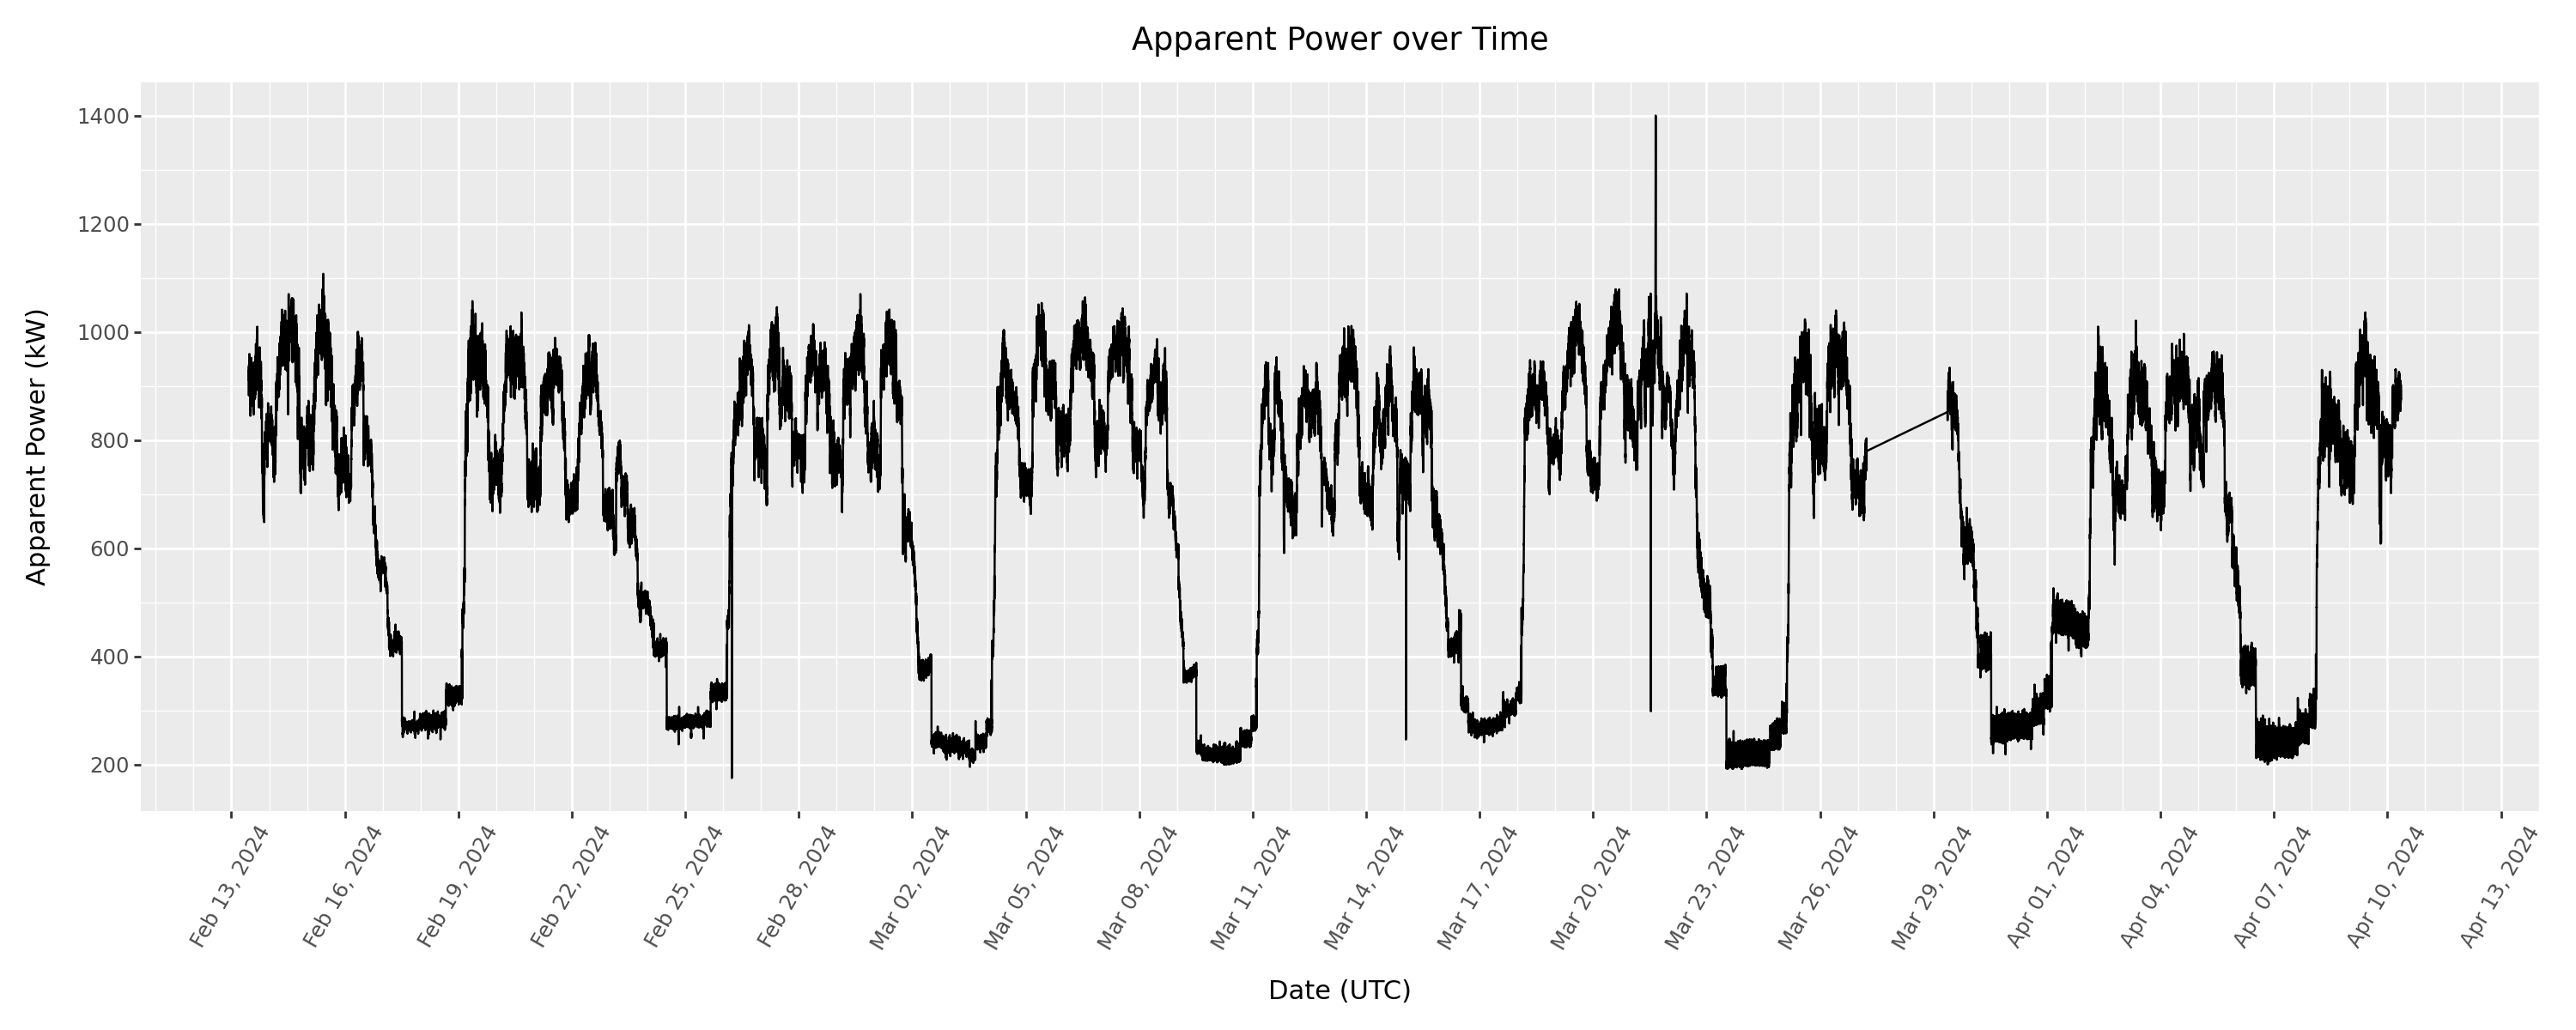

In [3]:
(
    ggplot(factory_energy, aes(x='at', y='papp'))
    + geom_line()
    + scale_x_datetime(date_breaks='3 day', date_minor_breaks='1 day', date_labels='%b %d, %Y')
    + scale_y_continuous(breaks=list(range(0, 1500, 200)))
    + theme(figure_size=(15, 6), axis_text_x=element_text(angle=60))
    + labs(x = 'Date (UTC)', y = 'Apparent Power (kW)', title = 'Apparent Power over Time')
)

# Linear Regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [5]:
# Function to process the data into # look_back days, # predict days slices
def convert_ts(data, look_back, look_forward):
    datX, datY = [], []
    for i in range(len(data)-look_back-look_forward+1):
        a = data[i:(i+look_back), :]
        datX.append(a)
        datY.append(data[i+look_back+look_forward-1, -1])
    return np.array(datX), np.array(datY).reshape(-1, 1)

In [6]:
data = factory_energy[['papp']]
n_train = math.floor(0.9 * len(data))

# apply normalization
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(data[['papp']][0:n_train])
test_scaled = scaler.transform(data[['papp']][n_train:])
dataset_scaled = np.concatenate((train_scaled, test_scaled), axis=0)

In [7]:
# convert data into lagged data
look_back = 30
look_forward = 5
dataX, dataY = convert_ts(dataset_scaled, look_back, look_forward)

print( dataX.shape, dataY.shape )

dataX = dataX.reshape(-1, look_back)
dataY = dataY.reshape(-1, 1)

# split training / test
trainX = dataX[0:(n_train-look_back), :]
trainY = dataY[0:(n_train-look_back), :]

testX = dataX[(n_train-look_back):, :]
testY = dataY[(n_train-look_back):, :]

print( trainX.shape, trainY.shape )
print( testX.shape, testY.shape )

(77105, 30, 1) (77105, 1)
(69395, 30) (69395, 1)
(7710, 30) (7710, 1)


In [8]:
# fit Linear model
model_linear = LinearRegression()
model_linear.fit(trainX, trainY)

# evaluate model with RMSE
train_preds = scaler.inverse_transform(model_linear.predict(trainX))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds ) ) )

test_preds = scaler.inverse_transform(model_linear.predict(testX))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds ) ) )

Training Error: 21.692124101260482
Testing Error: 24.15594406619901


In [9]:
model_linear_coefs = pd.DataFrame(
    model_linear.coef_.reshape(-1,1),
    index=['Lag ' + str(i+1) for i in reversed(range(look_back))], columns=['coef']
)
model_linear_coefs.sort_values(by=['coef'], key=abs, ascending=False)

,coef
Lag 1,0.588925
Lag 2,0.113312
Lag 3,0.082343
Lag 8,0.053958
Lag 4,0.051926
Lag 6,0.050214
Lag 11,-0.048479
Lag 23,-0.046966
Lag 15,0.046039
Lag 16,0.037646


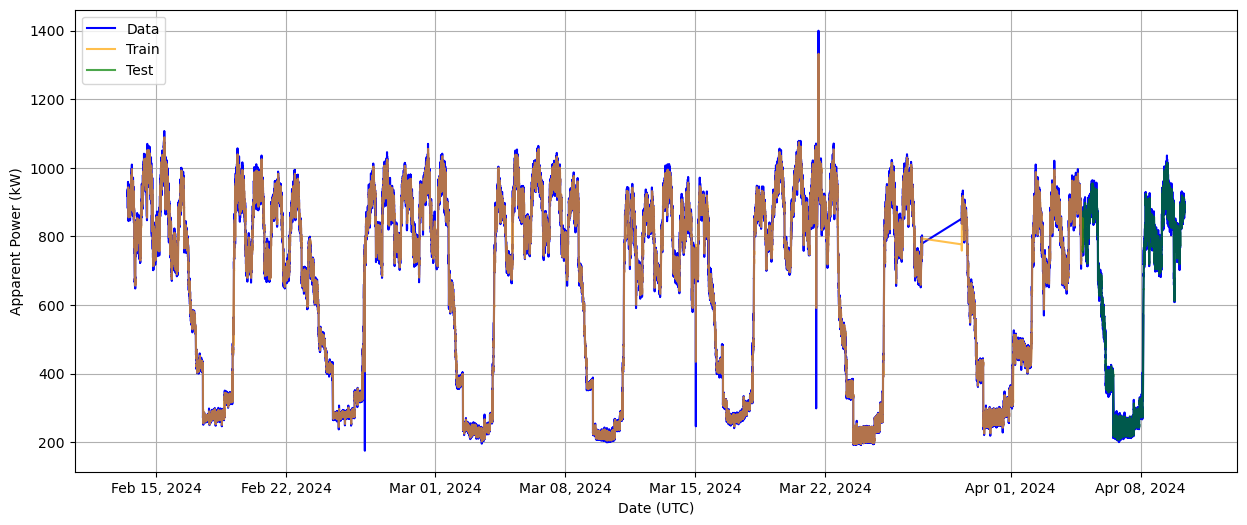

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_energy[['papp']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.empty_like(factory_energy[['papp']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds):look_back+look_forward-1+len(train_preds)+len(test_preds), :] = test_preds.reshape(-1,1)

plt.plot(factory_energy[['at']], factory_energy[['papp']], color='blue', label='Data')
plt.plot(factory_energy[['at']], train_predict_plot, color='orange', alpha=0.7, label='Train')
plt.plot(factory_energy[['at']], test_predict_plot, color='green', alpha=0.7, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Apparent Power (kW)')
plt.grid()
plt.show()

# Tree-Based Models

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [12]:
# fit decision tree model
model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(trainX, trainY)

# evaluate model with RMSE
train_preds_tree = scaler.inverse_transform(model_tree.predict(trainX).reshape(-1,1))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds_tree ) ) )

test_preds_tree = scaler.inverse_transform(model_tree.predict(testX).reshape(-1,1))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds_tree ) ) )

Training Error: 23.193892724952292
Testing Error: 26.07518663810748


In [13]:
model_tree_coefs = pd.DataFrame(
    model_tree.feature_importances_,
    index=['Lag ' + str(i+1) for i in reversed(range(look_back))], columns=['coef']
)
model_tree_coefs.sort_values(by=['coef'], key=abs, ascending=False)

,coef
Lag 1,0.995541
Lag 2,0.004263
Lag 9,0.000143
Lag 15,0.000052
Lag 26,0.000000
Lag 25,0.000000
Lag 28,0.000000
Lag 3,0.000000
Lag 4,0.000000
Lag 5,0.000000


In [14]:
# fit random forest model
model_forest = RandomForestRegressor(max_depth=5)
model_forest.fit(trainX, trainY)

# evaluate model with RMSE
train_preds_forest = scaler.inverse_transform(model_forest.predict(trainX).reshape(-1,1))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds_forest ) ) )

test_preds_forest = scaler.inverse_transform(model_forest.predict(testX).reshape(-1,1))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds_forest ) ) )

Training Error: 22.484952896552358
Testing Error: 25.261267885747134


In [15]:
model_forest_coefs = pd.DataFrame(
    model_forest.feature_importances_,
    index=['Lag ' + str(i+1) for i in reversed(range(look_back))], columns=['coef']
)
model_forest_coefs.sort_values(by=['coef'], key=abs, ascending=False)

,coef
Lag 1,8.943473e-01
Lag 2,1.055180e-01
Lag 15,2.444483e-05
Lag 3,1.984984e-05
Lag 14,1.970402e-05
Lag 19,1.052909e-05
Lag 26,7.505488e-06
Lag 16,6.506616e-06
Lag 24,5.751567e-06
Lag 27,5.696610e-06


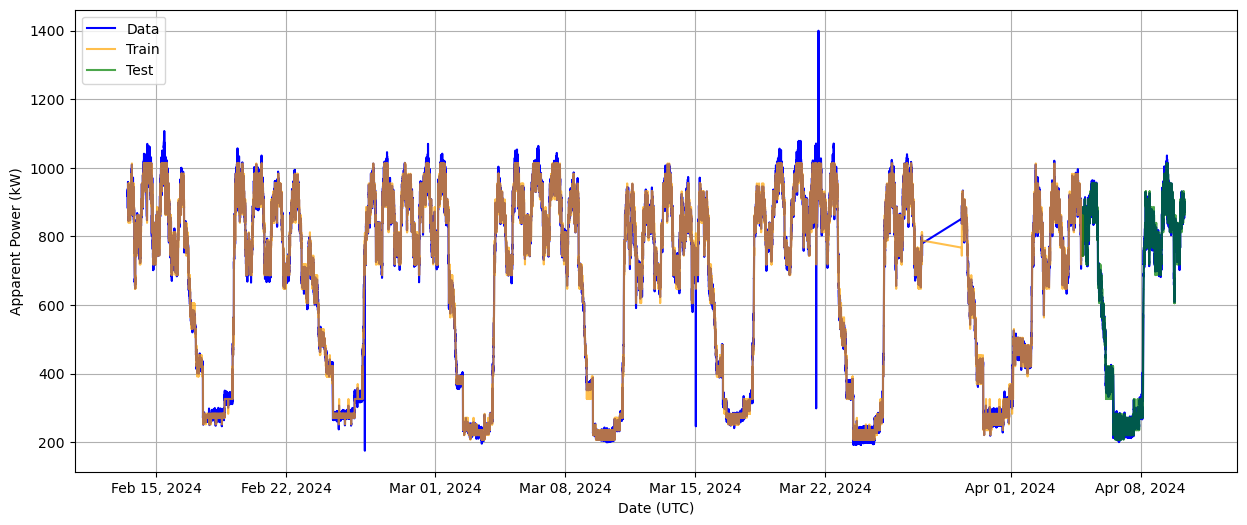

In [16]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_energy[['papp']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds_tree), :] = train_preds_tree.reshape(-1,1)

test_predict_plot = np.empty_like(factory_energy[['papp']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds_tree):look_back+look_forward-1+len(train_preds_tree)+len(test_preds_tree), :] = test_preds_tree.reshape(-1,1)

plt.plot(factory_energy[['at']], factory_energy[['papp']], color='blue', label='Data')
plt.plot(factory_energy[['at']], train_predict_plot, color='orange', alpha=0.7, label='Train')
plt.plot(factory_energy[['at']], test_predict_plot, color='green', alpha=0.7, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Apparent Power (kW)')
plt.grid()
plt.show()

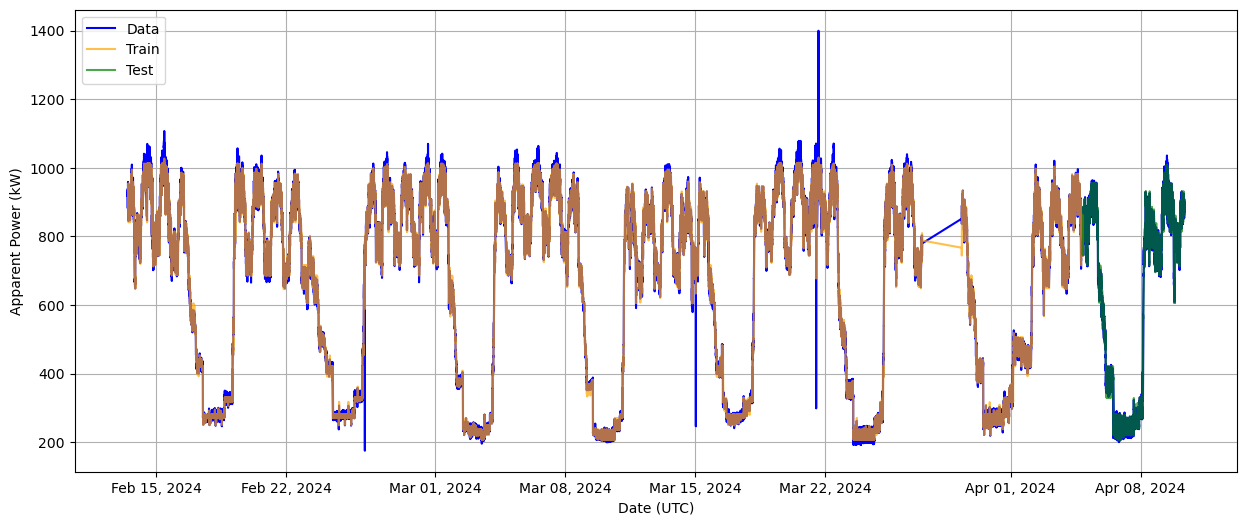

In [17]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_energy[['papp']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds_forest), :] = train_preds_forest.reshape(-1,1)

test_predict_plot = np.empty_like(factory_energy[['papp']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds_forest):look_back+look_forward-1+len(train_preds_forest)+len(test_preds_forest), :] = test_preds_forest.reshape(-1,1)

plt.plot(factory_energy[['at']], factory_energy[['papp']], color='blue', label='Data')
plt.plot(factory_energy[['at']], train_predict_plot, color='orange', alpha=0.7, label='Train')
plt.plot(factory_energy[['at']], test_predict_plot, color='green', alpha=0.7, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Apparent Power (kW)')
plt.grid()
plt.show()

# Recurrent Neural Net

In [18]:
from keras.api.models import Sequential
from keras.api.layers import Dense, LSTM, Dropout

In [19]:
# define model (20-layer LSTM)
def create_lstm():
    model = Sequential()
    model.add(LSTM(20))
    model.add(Dense(20))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    return model

In [20]:
# define model, criterion, and optimizer
model_rnn = create_lstm()
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# train model
model_hist = model_rnn.fit(
    trainX.reshape(-1, look_back, 1), trainY.reshape(-1, 1), epochs=50, batch_size=60*24*7
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.0777
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.0152
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0165
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0107
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.0091
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0084
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0071
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0066
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0060
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0056
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0053
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.0051
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.0049
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0048
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0046
Epoch 16/50
7/7 ━━━

In [21]:
# evaluate model with RMSE
train_preds_rnn = scaler.inverse_transform(model_rnn.predict(trainX))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds_rnn ) ) )

test_preds_rnn = scaler.inverse_transform(model_rnn.predict(testX))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds_rnn ) ) )

2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training Error: 23.467771346839754
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing Error: 26.167767063570995


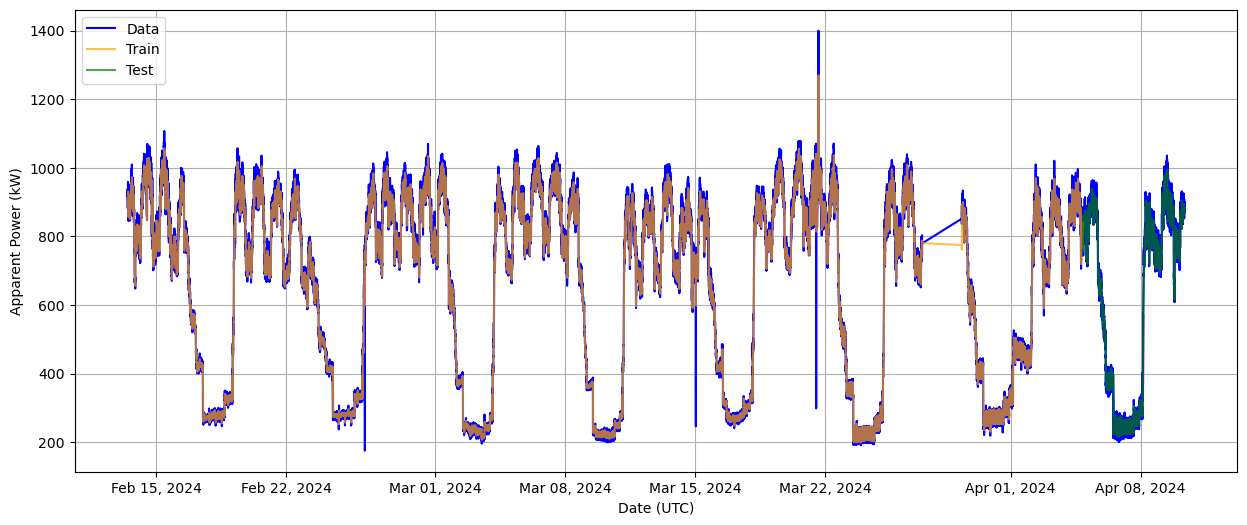

In [22]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_energy[['papp']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds_rnn), :] = train_preds_rnn.reshape(-1,1)

test_predict_plot = np.empty_like(factory_energy[['papp']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds_rnn):look_back+look_forward-1+len(train_preds_rnn)+len(test_preds_rnn), :] = test_preds_rnn.reshape(-1,1)

plt.plot(factory_energy[['at']], factory_energy[['papp']], color='blue', label='Data')
plt.plot(factory_energy[['at']], train_predict_plot, color='orange', alpha=0.7, label='Train')
plt.plot(factory_energy[['at']], test_predict_plot, color='green', alpha=0.7, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Apparent Power (kW)')
plt.grid()
plt.show()